In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [12]:
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

In [13]:
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
Y = house_prices_df.saleprice

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [15]:
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     383.1
Date:                Sun, 18 Aug 2019   Prob (F-statistic):               0.00
Time:                        23:43:54   Log-Likelihood:                -13972.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1157   BIC:                         2.802e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.039e+05   2.06e+04     -5.037      0.000   -1.44e+05   -6.34e+04
overallqual  2.433e+04   1244.706     19.548      0.000    2.19e+04    2.68e+04
grlivarea      43.3745      2.745     15.800      0.000      37.988      48.760
garagecars   1.407e+04   3409.600      4.126      0.000    7379.047    2.08e+04
garagearea     17.5210     11.560      1.516      0.130      -5.161      40.203
totalbsmtsf    23.4504      3.183      7.368      0.000      17.206      29.695
mszoning_FV  1.933e+04    1.5e+04      1.289      0.198   -1.01e+04    4.88e+04
mszoning_RH  7305.5078   1.72e+04      0.426      0.670   -2.63e+04     4.1e+04
mszoning_RL  2.429e+04   1.39e+04      1.747      0.081   -2983.478    5.16e+04
mszoning_RM  2864.3070   1.41e+04      0.203      0.839   -2.48e+04    3.05e+04
street_Pave -8177.6681   1.74e+04     -0.470      0.639   -4.23e+04     2.6e+04
==============================================================================
Omnibus:                      355.774   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30190.746
Skew:                          -0.383   Prob(JB):                         0.00
Kurtosis:                      27.895   Cond. No.                     5.62e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-square = 0.77 which is not bad but there is room for improvement.

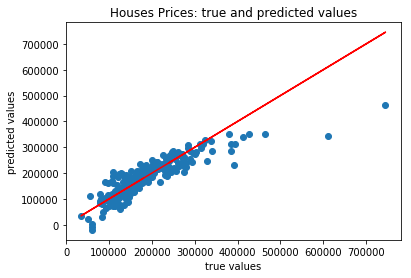

Mean absolute error of the prediction is: 25546.80382858886
Mean squared error of the prediction is: 1559083821.9730694
Root mean squared error of the prediction is: 39485.2354934483
Mean absolute percentage error of the prediction is: 15.551420347537784


In [16]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Houses Prices: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



The models looks better with house prices less than 300,000 dollars. for houses with a value more than 300,000 dollars the model under estimate the houses value compare to the true value of the house

In [17]:
Y2 = np.log1p(house_prices_df['saleprice'])
house_prices_df['grlivarea_garagearea'] = house_prices_df['grlivarea'] * house_prices_df['garagearea']
house_prices_df['grlivarea_overallqual'] = house_prices_df['grlivarea'] * house_prices_df['overallqual']
X2 = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'grlivarea_garagearea', 
                     'grlivarea_overallqual'] + dummy_column_names]

In [19]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X2_train.shape[0]))
print("The number of observations in test set is {}".format(X2_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [20]:
X2_train = sm.add_constant(X2_train)

results2 = sm.OLS(y2_train, X2_train).fit()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     484.5
Date:                Sun, 18 Aug 2019   Prob (F-statistic):               0.00
Time:                        23:45:07   Log-Likelihood:                 471.46
No. Observations:                1168   AIC:                            -916.9
Df Residuals:                    1155   BIC:                            -851.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.0256      0.101     99.101      0.000       9.827      10.224
overallqual               0.1291      0.012     10.517      0.000       0.105       0.153
grlivarea                 0.0004   3.85e-05      9.867      0.000       0.000       0.000
garagecars                0.0668      0.015      4.447      0.000       0.037       0.096
garagearea                0.0006   8.82e-05      6.351      0.000       0.000       0.001
totalbsmtsf               0.0001   1.38e-05      8.874      0.000    9.54e-05       0.000
grlivarea_garagearea  -2.807e-07   4.32e-08     -6.498      0.000   -3.65e-07   -1.96e-07
grlivarea_overallqual -2.952e-06   7.35e-06     -0.402      0.688   -1.74e-05    1.15e-05
mszoning_FV               0.4598      0.065      7.123      0.000       0.333       0.587
mszoning_RH               0.3064      0.073      4.170      0.000       0.162       0.451
mszoning_RL               0.4513      0.060      7.551      0.000       0.334       0.569
mszoning_RM               0.2789      0.061      4.596      0.000       0.160       0.398
street_Pave              -0.0560      0.074     -0.753      0.451      -0.202       0.090
==============================================================================
Omnibus:                      296.666   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1841.507
Skew:                          -1.020   Prob(JB):                         0.00
Kurtosis:                       8.803   Cond. No.                     2.73e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-Square is much better in this model and all other statistics 

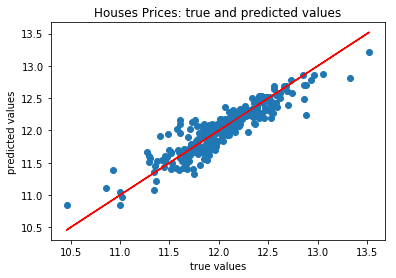

Mean absolute error of the prediction is: 0.12230696621655797
Mean squared error of the prediction is: 0.027391917504795072
Root mean squared error of the prediction is: 0.16550503770216504
Mean absolute percentage error of the prediction is: 1.02216059373925


In [23]:
X2_test = sm.add_constant(X2_test)

y2_preds = results2.predict(X2_test)

plt.scatter(y2_test, y2_preds)
plt.plot(y2_test, y2_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Houses Prices: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y2_test, y2_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y2_test, y2_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y2_test, y2_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y2_test - y2_preds) / y2_test)) * 100))


This model has a better prediction compare to the previous model. we can only use MAPE to compare both models because we made changes to the target variable. The MAPE decreased from 15.55 to 1.02. In addition from the plot we can see that the dots are close to the red line which mean that prediction error is less for this model